In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp '/content/drive/MyDrive/CSE 572 Data Mining/multiclass_data.zip' ./

In [3]:
!unzip -qq multiclass_data.zip


In [4]:
import numpy as np
import os
import tensorflow as tf
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import CategoricalCrossentropy

from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model



In [5]:
from keras import backend as K
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred[0])
    y_true_f = tf.cast(y_true_f, tf.float32)
    intersection = K.sum(y_true_f * y_pred_f)

    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [6]:
def loss_fn(y_true, y_pred):
    # y_pred = tf.expand_dims(y_pred, axis=-1)
    # print(y_pred.shape)
    # print(y_true.shape)
    # loss0 = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred[0], pos_weight=2, name=None)
    # loss1 = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred[1], pos_weight=2, name=None)
    # loss2 = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred[2], pos_weight=2, name=None)
    # loss3 = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred[3], pos_weight=2, name=None)
    # loss4 = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred[4], pos_weight=2, name=None)
    # loss5 = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred[5], pos_weight=2, name=None)
    # loss6 = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred[6], pos_weight=2, name=None)

    loss0 = cce(y_true, y_pred[0])
    loss1 = cce(y_true, y_pred[1])
    loss2 = cce(y_true, y_pred[2])
    loss3 = cce(y_true, y_pred[3])
    loss4 = cce(y_true, y_pred[4])
    loss5 = cce(y_true, y_pred[5])
    loss6 = cce(y_true, y_pred[6])
    return loss0 + loss1 + loss2 + loss3 + loss4 + loss5 + loss6
    # return 1 - dice_coef(y_true,y_pred)

def REBNCONV(x, out_ch=3, dirate=1):
    #x = ZeroPadding2D((1*dirate,1*dirate))(x)
    x = Conv2D(out_ch, 3, padding='same', dilation_rate = 1*dirate)(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    return x

def _upsample_like(src, tar):
    h = int(tar.shape[1]/src.shape[1])
    w = int(tar.shape[2]/src.shape[2])
    src = UpSampling2D((h,w), interpolation='bilinear')(src)
    return src

def RSU7(x, mid_ch=12, out_ch=3):

    x0 = REBNCONV(x, out_ch, 1)

    x1 = REBNCONV(x0, mid_ch, 1)
    x = MaxPool2D(2, 2)(x1)

    x2 = REBNCONV(x, mid_ch, 1)
    x = MaxPool2D(2, 2)(x2)

    x3 = REBNCONV(x, mid_ch, 1)
    x = MaxPool2D(2, 2)(x3)

    x4 = REBNCONV(x, mid_ch, 1)
    x = MaxPool2D(2, 2)(x4)

    x5 = REBNCONV(x, mid_ch, 1)
    x = MaxPool2D(2, 2)(x5)

    x6 = REBNCONV(x, mid_ch, 1)

    x = REBNCONV(x6, mid_ch, 2)

    x = REBNCONV(tf.concat([x,x6],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x5)

    x = REBNCONV(tf.concat([x,x5],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x4)

    x = REBNCONV(tf.concat([x,x4],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x3)

    x = REBNCONV(tf.concat([x,x3],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x2)

    x = REBNCONV(tf.concat([x,x2],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x1)

    x = REBNCONV(tf.concat([x,x1],axis=-1), out_ch, 1)

    return x + x0

def RSU6(x, mid_ch=12, out_ch=3):

    x0 = REBNCONV(x, out_ch, 1)

    x1 = REBNCONV(x0, mid_ch, 1)
    x = MaxPool2D(2, 2)(x1)

    x2 = REBNCONV(x, mid_ch, 1)
    x = MaxPool2D(2, 2)(x2)

    x3 = REBNCONV(x, mid_ch, 1)
    x = MaxPool2D(2, 2)(x3)

    x4 = REBNCONV(x, mid_ch, 1)
    x = MaxPool2D(2, 2)(x4)

    x5 = REBNCONV(x, mid_ch, 1)

    x = REBNCONV(x, mid_ch, 2)

    x = REBNCONV(tf.concat([x,x5],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x4)

    x = REBNCONV(tf.concat([x,x4],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x3)

    x = REBNCONV(tf.concat([x,x3],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x2)

    x = REBNCONV(tf.concat([x,x2],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x1)

    x = REBNCONV(tf.concat([x,x1],axis=-1), out_ch, 1)

    return x + x0

def RSU5(x, mid_ch=12, out_ch=3):

    x0 = REBNCONV(x, out_ch, 1)

    x1 = REBNCONV(x0, mid_ch, 1)
    x = MaxPool2D(2, 2)(x1)

    x2 = REBNCONV(x, mid_ch, 1)
    x = MaxPool2D(2, 2)(x2)

    x3 = REBNCONV(x, mid_ch, 1)
    x = MaxPool2D(2, 2)(x3)

    x4 = REBNCONV(x, mid_ch, 1)

    x = REBNCONV(x, mid_ch, 2)

    x = REBNCONV(tf.concat([x,x4],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x3)

    x = REBNCONV(tf.concat([x,x3],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x2)

    x = REBNCONV(tf.concat([x,x2],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x1)

    x = REBNCONV(tf.concat([x,x1],axis=-1), out_ch, 1)

    return x + x0

def RSU4(x, mid_ch=12, out_ch=3):

    x0 = REBNCONV(x, out_ch, 1)

    x1 = REBNCONV(x0, mid_ch, 1)
    x = MaxPool2D(2, 2)(x1)

    x2 = REBNCONV(x, mid_ch, 1)
    x = MaxPool2D(2, 2)(x2)

    x3 = REBNCONV(x, mid_ch, 1)

    x = REBNCONV(x, mid_ch, 2)

    x = REBNCONV(tf.concat([x,x3],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x2)

    x = REBNCONV(tf.concat([x,x2],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x1)

    x = REBNCONV(tf.concat([x,x1],axis=-1), out_ch, 1)

    return x + x0

def RSU4F(x, mid_ch=12, out_ch=3):

    x0 = REBNCONV(x, out_ch, 1)

    x1 = REBNCONV(x0, mid_ch, 1)
    x2 = REBNCONV(x1, mid_ch, 2)
    x3 = REBNCONV(x2, mid_ch, 4)

    x4 = REBNCONV(x3, mid_ch, 8)

    x = REBNCONV(tf.concat([x4,x3],axis=-1), mid_ch, 4)
    x = REBNCONV(tf.concat([x,x2],axis=-1), mid_ch, 2)
    x = REBNCONV(tf.concat([x,x1],axis=-1), out_ch, 1)

    return x + x0

def U2NET(x, out_ch=1):

    x1 = RSU7(x, 32, 64)
    x = MaxPool2D(2, 2)(x1)

    x2 = RSU6(x, 32, 128)
    x = MaxPool2D(2, 2)(x2)

    x3 = RSU5(x, 64, 256)
    x = MaxPool2D(2, 2)(x3)

    x4 = RSU4(x, 128, 512)
    x = MaxPool2D(2, 2)(x4)

    x5 = RSU4F(x, 256, 512)
    x = MaxPool2D(2, 2)(x5)

    x6 = RSU4F(x, 256, 512)
    x = _upsample_like(x6,x5)

    #-----------------decoder--------------------#

    x5 = RSU4F(tf.concat([x,x5],axis=-1),256, 512)
    x = _upsample_like(x5,x4)

    x4 = RSU4(tf.concat([x,x4],axis=-1),128, 256)
    x = _upsample_like(x4,x3)

    x3 = RSU5(tf.concat([x,x3],axis=-1),64, 128)
    x = _upsample_like(x3,x2)

    x2 = RSU6(tf.concat([x,x2],axis=-1),32, 64)
    x = _upsample_like(x2,x1)

    x1 = RSU7(tf.concat([x,x1],axis=-1),16, 64)

    #Side output
    x = ZeroPadding2D((1,1))(x1)
    d1 = Conv2D(out_ch, 3)(x)
    d1 = Activation('sigmoid')(d1)

    x = ZeroPadding2D((1,1))(x2)
    x = Conv2D(out_ch, 3)(x)
    d2 = _upsample_like(x,d1)
    d2 = Activation('sigmoid')(d2)

    x = ZeroPadding2D((1,1))(x3)
    x = Conv2D(out_ch, 3)(x)
    d3 = _upsample_like(x,d1)
    d3 = Activation('sigmoid')(d3)

    x = ZeroPadding2D((1,1))(x4)
    x = Conv2D(out_ch, 3)(x)
    d4 = _upsample_like(x,d1)
    d4 = Activation('sigmoid')(d4)

    x = ZeroPadding2D((1,1))(x5)
    x = Conv2D(out_ch, 3)(x)
    d5 = _upsample_like(x,d1)
    d5 = Activation('sigmoid')(d5)

    x = ZeroPadding2D((1,1))(x6)
    x = Conv2D(out_ch, 3)(x)
    d6 = _upsample_like(x,d1)
    d6 = Activation('sigmoid')(d6)

    d0 = Conv2D(out_ch, 1)(tf.concat([d1,d2,d3,d4,d5,d6],axis=-1))
    d0 = Activation('sigmoid')(d0)

    return tf.stack([d0,d1,d2,d3,d4,d5,d6])

def U2NETP(x, out_ch=5):

    x1 = RSU7(x, 16, 64)
    x = MaxPool2D(2, 2)(x1)

    x2 = RSU6(x, 16, 64)
    x = MaxPool2D(2, 2)(x2)

    x3 = RSU5(x, 16, 64)
    x = MaxPool2D(2, 2)(x3)

    x4 = RSU4(x, 16, 64)
    x = MaxPool2D(2, 2)(x4)

    x5 = RSU4F(x, 16, 64)
    x = MaxPool2D(2, 2)(x5)

    x6 = RSU4F(x, 16, 64)
    x = _upsample_like(x6,x5)

    #---------------decoder--------------------
    x5 = RSU4F(tf.concat([x,x5],axis=-1),16, 64)
    x = _upsample_like(x5,x4)

    x4 = RSU4(tf.concat([x,x4],axis=-1),16, 64)
    x = _upsample_like(x4,x3)

    x3 = RSU5(tf.concat([x,x3],axis=-1),16, 64)
    x = _upsample_like(x3,x2)

    x2 = RSU6(tf.concat([x,x2],axis=-1),16, 64)
    x = _upsample_like(x2,x1)

    x1 = RSU7(tf.concat([x,x1],axis=-1),16, 64)

    x = ZeroPadding2D((1,1))(x1)
    d1 = Conv2D(out_ch, 3)(x)
    d1 = Activation('softmax')(d1)

    x = ZeroPadding2D((1,1))(x2)
    x = Conv2D(out_ch, 3)(x)
    d2 = _upsample_like(x,d1)
    d2 = Activation('softmax')(d2)

    x = ZeroPadding2D((1,1))(x3)
    x = Conv2D(out_ch, 3)(x)
    d3 = _upsample_like(x,d1)
    d3 = Activation('softmax')(d3)

    x = ZeroPadding2D((1,1))(x4)
    x = Conv2D(out_ch, 3)(x)
    d4 = _upsample_like(x,d1)
    d4 = Activation('softmax')(d4)

    x = ZeroPadding2D((1,1))(x5)
    x = Conv2D(out_ch, 3)(x)
    d5 = _upsample_like(x,d1)
    d5 = Activation('softmax')(d5)

    x = ZeroPadding2D((1,1))(x6)
    x = Conv2D(out_ch, 3)(x)
    d6 = _upsample_like(x,d1)
    d6 = Activation('softmax')(d6)

    d0 = Conv2D(out_ch, 1)(tf.concat([d1,d2,d3,d4,d5,d6],axis=-1))
    d0 = Activation('softmax')(d0)

    return tf.stack([d0,d1,d2,d3,d4,d5,d6])

net_input = Input(shape=(512,512,3))

model_output = U2NETP(net_input)

model = Model(inputs = net_input, outputs = model_output)

lr = 1e-3

opt = tf.keras.optimizers.Adam(learning_rate = lr)

# bce = BinaryCrossentropy()
cce = CategoricalCrossentropy()

model.compile(optimizer = opt, loss = loss_fn, metrics = [dice_coef])


In [10]:
def default_unet():
    z1 = Input(shape=(512,512,3))
    print('z1: {}'.format(z1.shape))

    z2 = Conv2D(16, 3, padding='same', activation='relu')(z1)
    p2 = AveragePooling2D(pool_size=2)(z2)
    print('z2: {}, \np2: {}'.format(z2.shape, p2.shape))

    z3 = Conv2D(24, 3, padding='same', activation='relu')(p2)
    p3 = AveragePooling2D(pool_size=2)(z3)
    print('z3: {}, \np3: {}'.format(z3.shape, p3.shape))

    z4 = Conv2D(32, 3, padding='same', activation='relu')(p3)
    d4 = Dropout(0.2)(z4)
    p4 = AveragePooling2D(pool_size=2)(d4)
    print('z4: {}, \np4: {}'.format(z4.shape, p4.shape))

    z5 = Conv2D(48, 3, padding='same', activation='relu')(p4)
    d5 = Dropout(0.2)(z5)
    p5 = AveragePooling2D(pool_size=2)(d5)
    print('z5: {}'.format(z5.shape))

    z6 = Conv2D(64, 3, padding='same', activation='relu')(p5)
    d6 = Dropout(0.3)(z6)
    p6 = AveragePooling2D(pool_size=2)(d6)

    z7 = Conv2D(96, 3, padding='same', activation='relu')(p6)
    d7 = Dropout(0.4)(z7)
    p7 = AveragePooling2D(pool_size=2)(d7)

    z8 = Conv2D(128, 3, padding='same', activation='relu')(p7)
    d8 = Dropout(0.5)(z8)
    p8 = AveragePooling2D(pool_size=2)(d8)

    z9 = Conv2D(128, 3, padding='same', activation='relu')(p8)
    d9 = Dropout(0.5)(z9)

    u9 = UpSampling2D(size=2)(d9)
    q9 = Conv2D(128, 3, padding='same', activation='relu')(u9)
    d9b = Dropout(0.5)(q9)
    a9 = Add()([d9b,z8])

    u8 = UpSampling2D(size=2)(a9)
    q8 = Conv2D(96, 3, padding='same', activation='relu')(u8)
    d8b = Dropout(0.4)(q8)
    a8 = Add()([d8b,z7])

    u7 = UpSampling2D(size=2)(a8)
    q7 = Conv2D(64, 3, padding='same', activation='relu')(u7)
    d7b = Dropout(0.3)(q7)
    a7 = Add()([d7b,z6])

    u6 = UpSampling2D(size=2)(a7)
    q6 = Conv2D(48, 3, padding='same', activation='relu')(u6)
    d6b = Dropout(0.2)(q6)
    a6 = Add()([d6b,z5])

    u5 = UpSampling2D(size=2)(a6)
    q5 = Conv2D(32, 3, padding='same', activation='relu')(u5)
    d5b = Dropout(0.2)(q5)
    a5 = Add()([d5b,z4])

    u4 = UpSampling2D(size=2)(a5)
    q4 = Conv2D(24, 3, padding='same', activation='relu')(u4)
    a4 = Add()([q4,z3])

    u3 = UpSampling2D(size=2)(a4)
    q3 = Conv2D(16, 3, padding='same', activation='relu')(u3)
    a3 = Add()([q3,z2])

    z_final = Conv2D(5, 3, padding='same', activation='softmax')(a3)
    #z8 activation = sigmoid or softmax

    return Model(inputs = z1, outputs = z_final)

In [9]:
model = default_unet()

z1: (None, 512, 512, 3)
z2: (None, 512, 512, 16), 
p2: (None, 256, 256, 16)
z3: (None, 256, 256, 24), 
p3: (None, 128, 128, 24)
z4: (None, 128, 128, 32), 
p4: (None, 64, 64, 32)
z5: (None, 64, 64, 48)


In [ ]:
model.summary()

In [13]:
color_dict = {'Other':(255,0,255),'Secondary':(0,0,255),'Buried':(255,0,0),'Layered':(0,255,0),'Black':(0,0,0)}
label_codes = [(255,0,255),(0,0,255),(255,0,0),(0,255,0),(0,0,0)]
label_names = ['Other','Secondary','Buried','Layered']

In [14]:
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}

In [15]:
name2id = {v:k for k,v in enumerate(label_names)}
id2name = {k:v for k,v in enumerate(label_names)}

In [16]:
# id2name

In [17]:
def rgb_to_onehot(rgb_image, colormap = id2code):
    '''Function to one hot encode RGB mask labels
        Inputs:
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,)
    encoded_image = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(colormap):
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
    return encoded_image


def onehot_to_rgb(onehot, colormap = id2code):
    '''Function to decode encoded mask labels
        Inputs:
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3)
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

In [31]:
# timg = cv2.imread('multiclass_data/test/mask/thm_dir_N00_120_0_30_120_150512.png')
# timg = rgb_to_onehot(timg, id2code)
# print(np.unique(timg))

In [9]:
from tensorflow.keras.utils import Sequence
import numpy as np
import cv2
import os
from glob import glob

class Mygenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = glob(x_set+'/*.png'), glob(y_set+'/*.png')
        self.batch_size = batch_size
        self.indices = np.arange(np.asarray(self.x).shape[0])

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = np.array(self.x)[inds]
        batch_y = np.array(self.y)[inds]

        # read your data here using the batch lists, batch_x and batch_y
        x = []
        y = []
        for filename in batch_x:
            # print(filename)
            img = cv2.imread(filename)
            # if(img.shape[0]<512):
            #   img = cv2.copyMakeBorder(img, 128, 128, 128, 128, cv2.BORDER_CONSTANT)
            # else:
            # img = cv2.resize(img,(512,512))
            img = img/255
            x.append(img)

        for filename in batch_y:
            img = cv2.imread(filename)
            # if(img.shape[0]<512):
            #   img = cv2.copyMakeBorder(img, 128, 128, 128, 128, cv2.BORDER_CONSTANT)
            # else:
            # img = cv2.resize(img,(512,512))

            # img = np.where(img>0, 1, 0).astype(np.float32)
            img = rgb_to_onehot(img, id2code)
            y.append(img)

        return np.array(x), np.array(y)

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

In [33]:
# train = Mygenerator('multiclass_data/train/images','multiclass_data/train/mask',4)
# val = Mygenerator('multiclass_data/val/images','multiclass_data/val/mask',4)

In [34]:
# np.unique(train.__getitem__(0)[1][1])

In [10]:
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
# tr_img,tr_mask = gen('train')
# train = zip(tr_img,tr_mask)
# vl_img,vl_mask = gen('val')
# val = zip(vl_img,vl_mask)

checkpoint = ModelCheckpoint(
    'modelunet_mc.h5',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto'

)
train = Mygenerator('multiclass_data/train/images','multiclass_data/train/mask',4)
val = Mygenerator('multiclass_data/val/images','multiclass_data/val/mask',4)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=4,
    verbose=1,
    min_lr=1e-6,
    min_delta=0.05
)
# model = default_unet()
# model.compile(optimizer=Adam(lr=1e-3),
#                   loss='categorical_crossentropy',
#                   metrics=[dice_coef])
# # model.compile(optimizer = opt, loss = loss, metrics = [dice_coef])

STEP_SIZE_TRAIN=3375//16
STEP_SIZE_VALID=1800//16

# STEP_SIZE_TRAIN=tr_img.n//tr_img.batch_size
# STEP_SIZE_VALID=vl_img.n//vl_img.batch_size
history = model.fit_generator(train,steps_per_epoch=STEP_SIZE_TRAIN,validation_data=val,validation_steps=STEP_SIZE_VALID,epochs=7, callbacks=[ reduce_lr,checkpoint])

<ipython-input-10-a344d3828b77>:36: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train,steps_per_epoch=STEP_SIZE_TRAIN,validation_data=val,validation_steps=STEP_SIZE_VALID,epochs=7, callbacks=[ reduce_lr,checkpoint])


Epoch 1/7
210/210 [==============================] - 317s 955ms/step - loss: 3.3044 - dice_coef: 0.2980 - val_loss: 3.4413 - val_dice_coef: 0.5335 - lr: 0.0010
Epoch 2/7
210/210 [==============================] - 193s 921ms/step - loss: 2.0526 - dice_coef: 0.6648 - val_loss: 2.2648 - val_dice_coef: 0.7663 - lr: 0.0010
Epoch 3/7
210/210 [==============================] - 193s 921ms/step - loss: 1.8798 - dice_coef: 0.7949 - val_loss: 1.9190 - val_dice_coef: 0.8184 - lr: 0.0010
Epoch 4/7
210/210 [==============================] - 192s 913ms/step - loss: 1.7386 - dice_coef: 0.8414 - val_loss: 6.7311 - val_dice_coef: 0.6629 - lr: 0.0010
Epoch 5/7
210/210 [==============================] - 207s 983ms/step - loss: 1.6376 - dice_coef: 0.8663 - val_loss: 1.7234 - val_dice_coef: 0.8703 - lr: 0.0010
Epoch 6/7
210/210 [==============================] - 193s 921ms/step - loss: 1.5227 - dice_coef: 0.8810 - val_loss: 1.2801 - val_dice_coef: 0.8958 - lr: 0.0010
Epoch 7/7
210/210 [=====================

In [11]:
model.save('model2net_mc.h5')

In [9]:
model.load_weights('model2net_mc.h5')

In [37]:
model.load_weights('modelunet_mc.h5')

In [10]:
import cv2
img_data = []
pred_data = []
true_mask = []
for files in sorted(os.listdir('multiclass_data/test/images/')):
    # print(files)
    if(files[0]!='.'):
        img = cv2.imread('multiclass_data/test/images/'+files)
        img = cv2.resize(img,(512,512))
        preds = model.predict(img.reshape((1,512,512,3))/255)
        # print(preds.shape)
        img_data.append(img)
        pred_data.append(preds[0].reshape((512,512,5)))
        truth = cv2.imread('multiclass_data/test/mask/'+files)
        true_mask.append(truth)

1/1 [==============================] - 0s 32ms/step


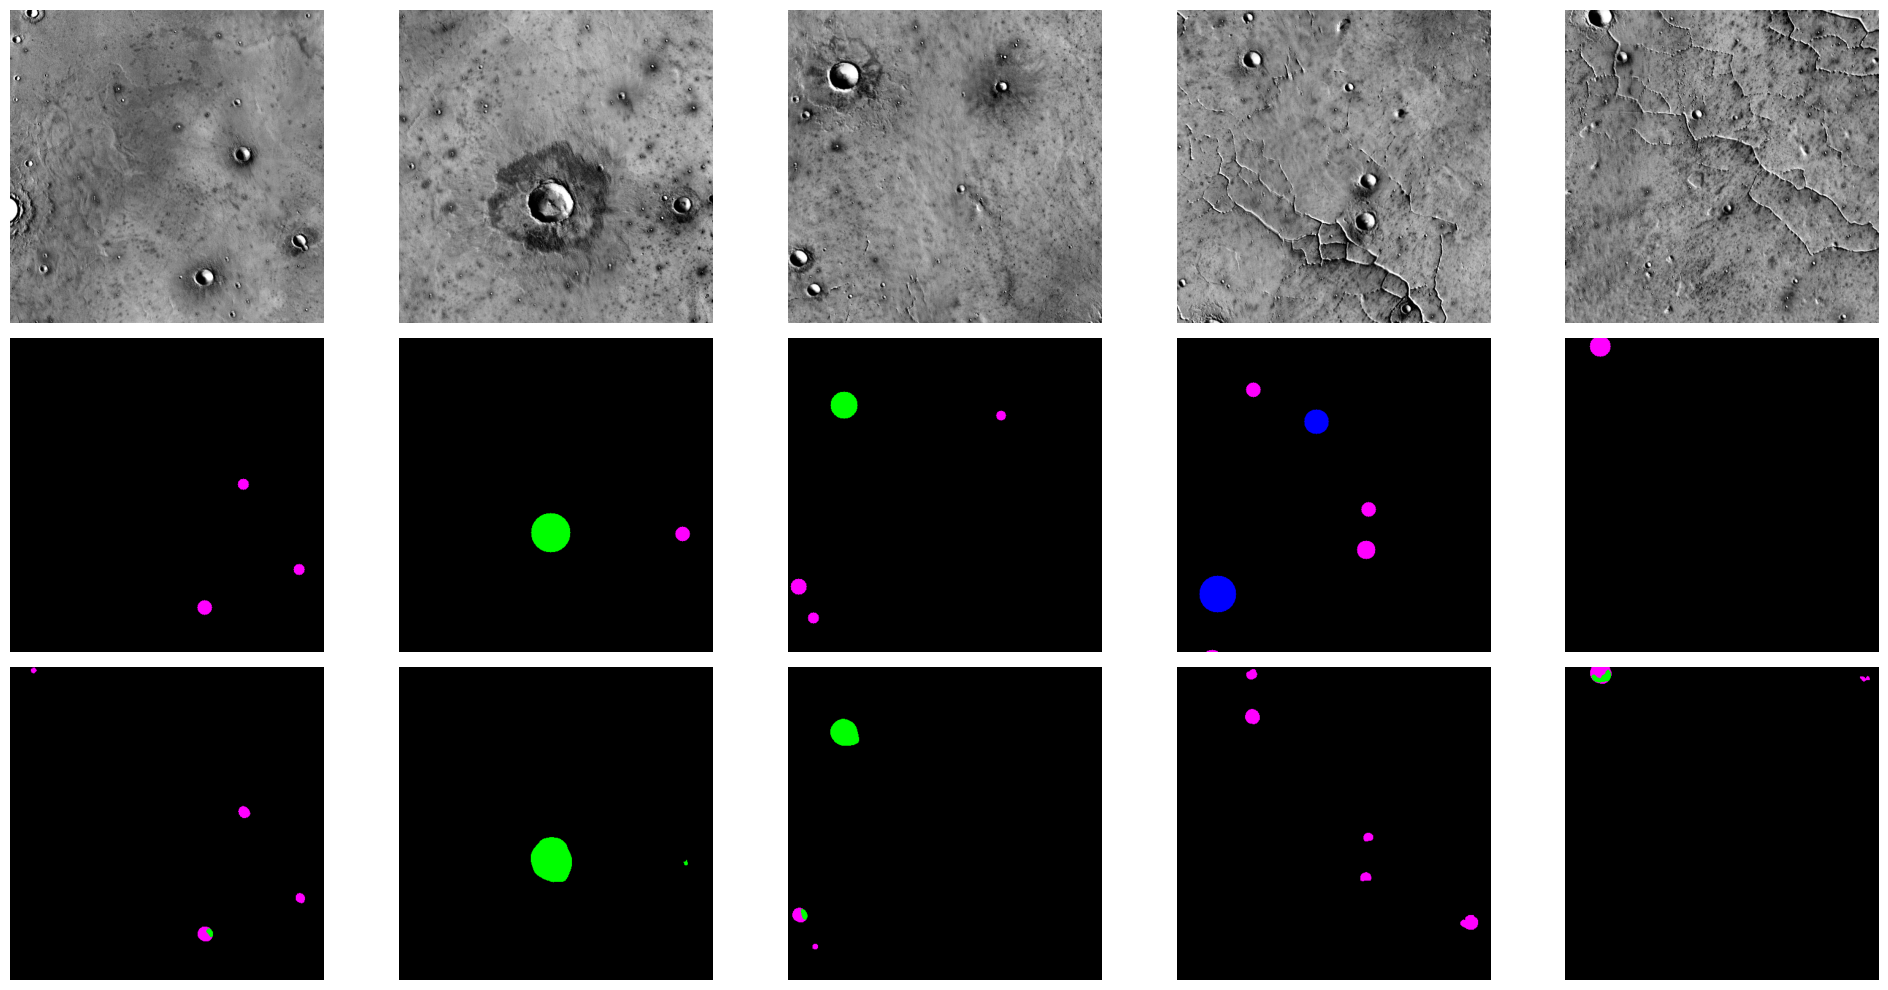

In [20]:
# Plot some random training examples from each dataset

import matplotlib.pyplot as plt
import numpy as np
# Set the random seed
np.random.seed(0)

n = 5

fig, axes = plt.subplots(ncols=n, nrows=3, figsize=(20,10))
for i in range(n):
    # rand = np.random.randint(0, mnist_x_train.shape[0])
    axes[0,i].imshow(cv2.cvtColor(img_data[i], cv2.COLOR_BGR2RGB))
    axes[0,i].axis('off')
    axes[1,i].imshow(cv2.cvtColor(true_mask[i], cv2.COLOR_BGR2RGB))
    axes[1,i].axis('off')
    axes[2,i].imshow(cv2.cvtColor(onehot_to_rgb(pred_data[i],id2code), cv2.COLOR_BGR2RGB))
    axes[2,i].axis('off')

fig.tight_layout()